# Compare $W(k, k^{\prime}) \times P_{\mathrm{cubic}}(k^{\prime})$ and $P_{\mathrm{cutsky}}(k)$ to validate window computation

In [1]:
import os
import sys

import numpy as np
from matplotlib import pyplot as plt

from desilike.samples import Profiles

sys.path.append('../bin')
from utils import load_poles, load_poles_list
from desi_file_manager import DESIFileName
from local_file_manager import LocalFileName
from window import WindowRotation

# plotting
plt.style.use(os.path.join(os.path.abspath('../bin'), 'plot_style.mplstyle'))
plots_dir = '../../plots/'

### Global parameters

In [2]:
# official desi ('desi') or locally ('local') generated window/pk
source = 'desi'
cubicsource = 'desi'

# mocks/version
catalog = 'second'
version = 'v4_1'
imocks = range(25)

# tracer
tracer = 'ELG_LOP'
region = 'GCcomb'
completeness = 'complete'
zrange = (1.1, 1.6)
z = 1.325

# multipoles
ells = (0, 2, 4)
ktmax = 0.35
krange = (0.02, 0.2, 0.005)

# cut
rpcut = 0.
thetacut = 0.05

## Window matrix $W(k, k^{\prime})$

In [3]:
fdir = "/global/cfs/cdirs/desi/users/mpinon/secondGenMocksY1/{}/rotated_window".format(version)

rotatedwm_fn = LocalFileName().set_default_config(ftype='rotated_all', tracer=tracer, region=region, completeness=completeness, realization=None, rpcut=rpcut, thetacut=thetacut)
rotatedwm_fn.update(fdir=fdir, zrange=zrange, cellsize=None, boxsize=None, directedges=False)
rotatedwm_fn.rotation_attrs['csub'] = False
rotatedwm = WindowRotation.load(rotatedwm_fn.get_path())
wm = rotatedwm.wmatrix
wm.value = rotatedwm.rotate()[0].T

koutrebin = 1
wm.slice_x(sliceout=slice(0, len(wm.xout[0]) // koutrebin * koutrebin, koutrebin))
wm.select_x(xoutlim=(krange[0], krange[1]))
kinrebin = 10
wm.slice_x(slicein=slice(0, len(wm.xin[0]) // kinrebin * kinrebin, kinrebin))
wm.select_x(xinlim=(0.001, ktmax))

mmatrix = rotatedwm.mmatrix[0]
mo = np.array(rotatedwm.mmatrix[1])
cov = np.matmul(np.matmul(mmatrix, rotatedwm.covmatrix), mmatrix.T)

In [4]:
rotatedwm_fn.get_path()

'/global/cfs/cdirs/desi/users/mpinon/secondGenMocksY1/v4_1/rotated_window/rotated_all_ELG_LOP_complete_GCcomb_z1.1-1.6_thetacut0.05_ells024_kobsmax0.4_ktmax0.5_maxsigW5_maxsigR5_factordiffell10_analyticcov.npy'

## $P_{\mathrm{cubic}}(k)$

In [5]:
if cubicsource == 'local':
    fn = LocalFileName()
    fn.set_default_config(mockgen='cubic', tracer=tracer, z=z)
    cubic_pk = load_poles_list([fn.get_path(realization=imock, los=los) for los in ('xyz') for imock in range(25)])

if cubicsource == 'desi':
    fn = DESIFileName()
    fn.set_default_config(mocktype='SecondGenMocks/CubicBox', tracer=tracer, zrange=z, version='v1.1')
    cubic_pk = load_poles_list([fn.get_path(realization=imock, los=los) for los in ('xyz') for imock in range(25)])

In [6]:
fn.get_path()

'/global/cfs/cdirs/desi/cosmosim/SecondGenMocks/CubicBox/desipipe/v1.1/2pt/mock24_los-z/pk/pkpoles_ELG_z1.3250_lin_cellsize2_boxsize2000.npy'

### Model fitted on $P_{\mathrm{cubic}}(k)$

In [7]:
data_dir = '/global/cfs/cdirs/desi/users/mpinon/cubicSecondGenMocks{}/z{:.3f}'.format('/desi/v1.1' if cubicsource=='desi' else '', z)

template_name = 'shapefitqisoqap'

emulator_dir = os.path.join(data_dir, 'emulators/emulators_{}_ELG'.format(template_name))
profiles_dir = os.path.join(data_dir, 'profiles/profiles_{}_ELG'.format(template_name))
profile_cubic = Profiles.load(os.path.join(profiles_dir, 'power_velocileptors_ezmockscov.npy'))

In [8]:
#likelihood = get_power_likelihood(data_type=data_type, tracer=tracer, region=region, completeness='complete_', solve=False, fc='', rp_cut=rp_cut, emulator_fn=os.path.join(emulator_dir.format('complete_'), '{}_{{}}.npy'.format(stat)))

#likelihood.solved_default = '.best'
#likelihood(**profile_cubic.bestfit.choice(input=True))
#box_obs = likelihood.observables[0]
#box_theory = box_obs.theory

In [9]:
os.path.join(profiles_dir, 'power_velocileptors.npy')

'/global/cfs/cdirs/desi/users/mpinon/cubicSecondGenMocks/desi/v1.1/z1.325/profiles/profiles_shapefitqisoqap_ELG/power_velocileptors.npy'

### Theory from fitted $P_{\mathrm{cubic}}(k)$

In [10]:
from emulator_fit import get_fit_setup, get_template
from desilike.theories.galaxy_clustering import LPTVelocileptorsTracerPowerSpectrumMultipoles

template = get_template(template_name=template_name, z=z)

theory = LPTVelocileptorsTracerPowerSpectrumMultipoles(template=template, ells=ells, k=wm.xin[0], prior_basis='physical', freedom='max', tracer=tracer[:3])
pk_theory = theory(**profile_cubic.bestfit.choice(input=True))

/global/common/software/desi/users/adematti/perlmutter/cosmodesiconda/20240118-1.0.0/code/cosmoprimo/main/lib/python3.10/site-packages/cosmoprimo/eisenstein_hu.py:23: UserWarning: EisensteinHuNoWiggleEngine cannot cope with massive neutrinos
  warnings.warn('{} cannot cope with massive neutrinos'.format(self.__class__.__name__))


### Check cubic fit

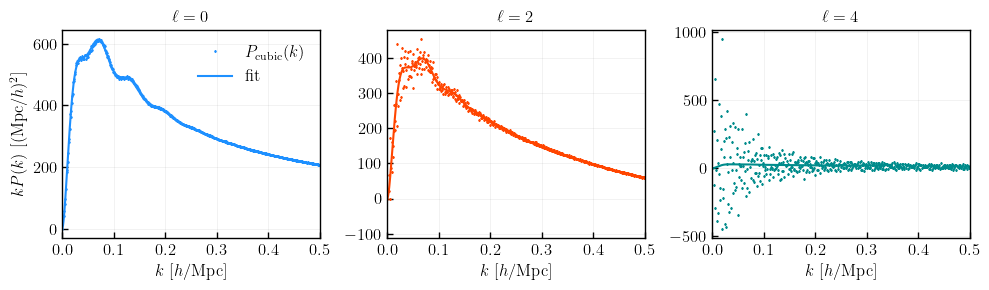

In [11]:
fig, axes = plt.subplots(1, 3, figsize=(10, 3), sharey=False)

for ill, ell in enumerate(ells):
    axes[ill].plot(cubic_pk['k'][ill], cubic_pk['k'][ill] * cubic_pk['data'][ill], color='C{}'.format(ill), marker='d', markersize=1, ls='', label=r'$P_{\mathrm{cubic}}(k)$')
    axes[ill].plot(wm.xin[ill], wm.xin[ill] * pk_theory[ill], color='C{}'.format(ill), ls='-', label=r'fit')
    axes[ill].set_title(r'$\ell={}$'.format(ell))
    axes[ill].set_xlabel(r'$k$ [$h$/Mpc]')
    axes[ill].set_xlim((0, 0.5))
    
axes[0].set_ylabel(r'$k P(k)$ [$(\mathrm{Mpc}/h)^{2}$]')
axes[0].legend()
plt.show()

### $W(k, k^{\prime}) \times P_{\mathrm{theory}}(k^{\prime})$

In [12]:
wm_pk = (wm.value.T.dot(pk_theory.flatten())).reshape((len(ells), wm.shape[1]//len(ells)))

## $P_{\mathrm{cutsky}}(k)$

In [13]:
if source == 'desi':
    fn = DESIFileName()
    fn.set_default_config(version=version, tracer=tracer, region=region, completeness=completeness)
elif source == 'local':
    fn = LocalFileName()
    fn.set_default_config(mockgen=catalog, tracer=tracer, region=region, completeness=completeness)
    fn.update(cellsize=6)
    
cutsky_pk = load_poles_list([fn.get_path(realization=imock, rpcut=rpcut, thetacut=thetacut, zrange=zrange) for imock in range(25)], xlim={ell: (0, 0.4, 0.005) for ell in ells})

In [14]:
fn.get_path()

'/global/cfs/cdirs/desi/survey/catalogs/Y1/mocks/SecondGenMocks/AbacusSummit/desipipe/v4_1/complete/baseline_2pt/mock24/pk/pkpoles_ELG_LOP_GCcomb_z1.1-1.6_thetacut0.05.npy'

In [15]:
mask = (np.arange(0, 0.4, 0.005) >= krange[0]) & (np.arange(0, 0.4, 0.005) < krange[1])
mask_flat = np.concatenate((mask, )*len(ells))

cutsky_pk_new = np.matmul(mmatrix, cutsky_pk['data'].flatten()).reshape((len(ells), len(cutsky_pk['data'].flatten())//len(ells)))
cutsky_pk_new = cutsky_pk_new[:, mask]

### Y1 covariance

In [16]:
from cov_utils import truncate_cov, get_EZmocks_covariance
#cov_fn = '/global/cfs/cdirs/desi/users/mpinon/Y1/cov/cov_gaussian_pre_ELG_LOPnotqso_{}_{:.1f}_{:.1f}_default_FKP_lin.txt'.format(region, zrange[0], zrange[1])
#cov = np.loadtxt(cov_fn)
#cov = truncate_cov(cov, kinit=np.arange(0., 0.4, 0.005), kfinal=np.arange(*krange))

cov_fn = '/global/cfs/cdirs/desi/users/mpinon/Y1/cov/pk/cov_EZmocks_{}_ffa_{}_z{:.3f}-{:.3f}_k{:.2f}-{:.2f}{}.npy'.format(tracer[:7], region, zrange[0], zrange[1], 0, 0.4, '_thetacut{:.2f}'.format(thetacut) if thetacut else '')
if not os.path.isfile(cov_fn):
    cov = get_EZmocks_covariance(stat='pkpoles', tracer=tracer, region=region, zrange=zrange, completeness='ffa', ells=(0, 2, 4), select=(0, 0.4, 0.005), rpcut=rpcut, thetacut=thetacut, return_x=False)
else:
    cov = np.load(cov_fn)
covnew = mmatrix.dot(cov)
covnew = truncate_cov(covnew, kinit=np.arange(0., 0.4, 0.005), kfinal=np.arange(*krange))

stdY1 = np.sqrt(np.diag(covnew)).reshape((3, len(covnew[0])//3))

In [19]:
print(cov_fn)

/global/cfs/cdirs/desi/users/mpinon/Y1/cov/pk/cov_EZmocks_ELG_LOP_ffa_GCcomb_z1.100-1.600_k0.00-0.40_thetacut0.05.npy


In [17]:
def chi2(m):
    precmatrix = np.linalg.inv(covnew)
    r = (wm_pk - cutsky_pk_new + (m.dot(mo[:, mask_flat])).reshape(wm_pk.shape)).flatten()
    res = r.T.dot(precmatrix.dot(r))
    return res

from scipy.optimize import minimize

minimizer = minimize(chi2, x0=np.array([1, 1, 1]))
print(minimizer)
m = minimizer.x
mmo = (m.dot(mo[:, mask_flat])).reshape(wm_pk.shape)

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 3.792024906428882
        x: [-3.998e+02  2.455e+01  1.087e+01]
      nit: 23
      jac: [-2.682e-07 -1.460e-06  5.960e-08]
 hess_inv: [[ 9.412e+01  6.867e+00  3.351e+00]
            [ 6.867e+00  3.266e+01  1.165e+01]
            [ 3.351e+00  1.165e+01  1.564e+02]]
     nfev: 108
     njev: 27


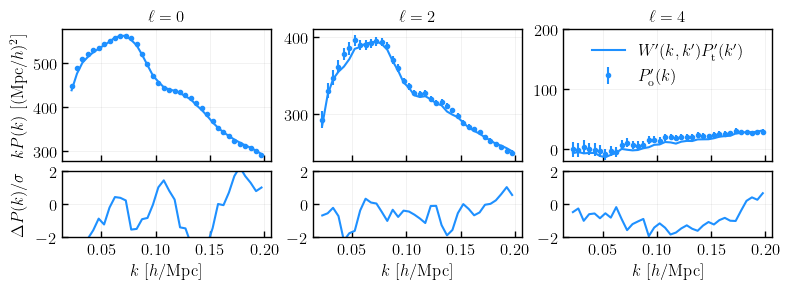

In [18]:
plt.rcParams["figure.autolayout"] = False
fig, axes = plt.subplots(2, 3, figsize=(8, 3), sharey=False, sharex=True, gridspec_kw={'height_ratios': [4, 2]})

for ill, ell in enumerate(ells):
    axes[0][ill].errorbar(cutsky_pk['k'][ill][mask], cutsky_pk['k'][ill][mask] * cutsky_pk_new[ill], cutsky_pk['k'][ill][mask]*stdY1[ill]/5, color='C0', marker='.', ls='', label=r'$P^{\prime}_{\mathrm{o}}(k)$')
    axes[0][ill].plot(wm.xout[ill], wm.xout[ill] * (wm_pk[ill] + mmo[ill]), color='C0', label=r'$W^{\prime}(k, k^{\prime}) P^{\prime}_{\mathrm{t}}(k^{\prime})$')
    axes[0][ill].set_title(r'$\ell={}$'.format(ell))
    #axes[0][ill].set_ylim(ymin=0)
    
    axes[1][ill].plot(wm.xout[ill], (wm_pk[ill] + mmo[ill] - cutsky_pk_new[ill])/(stdY1[ill]/5), color='C0')
    axes[1][ill].set_xlabel(r'$k$ [$h$/Mpc]')
    axes[1][ill].set_ylim((-2, 2))

axes[0][2].set_ylim(ymax=200)
axes[0][0].set_ylabel(r'$k P(k)$ [$(\mathrm{Mpc}/h)^{2}$]')
axes[1][0].set_ylabel(r'$\Delta P(k) / \sigma$')
axes[0][2].legend(loc='upper center')
fig.align_ylabels()
plt.tight_layout()
plt.subplots_adjust(wspace=0.2, hspace=0.1)
plt.savefig(os.path.join(plots_dir, version, cubicsource, 'window_sculpt_validation_{}mocks{}_{}cut{:.2f}_{}_{}_z{:.2f}-{:.2f}_ktmax{}.pdf'.format(len(imocks), '_ffa' if completeness=='ffa' else '_complete' if completeness else '_altmtl', 'rp' if rpcut else 'theta', max(rpcut, thetacut), tracer, region, zrange[0], zrange[1], ktmax)), dpi=200)
plt.show()